<a href="https://colab.research.google.com/github/Afes4/Proyecto-IA/blob/main/2_OCRKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importar librerias**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **Cargando el dataset**

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  9175k      0 --:--:-- --:--:-- --:--:-- 21.1M


In [3]:
# Ruta al directorio de datos
data_dir = Path("./captcha_images_v2/")

# Obtener una lista de todas las imágenes
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Tamaño de lote para entrenamiento y validación
batch_size = 16

# Dimensiones deseadas de la imagen
img_width = 200
img_height = 50

# Factor por el cual se reducirá la resolución de la imagen
# por los bloques convolucionales. Usaremos dos
# bloques de convolución y cada bloque tendrá
# una capa de agrupación que reduce la muestra de las características por un factor de 2.
# Por lo tanto, el factor de reducción de muestreo total sería 4.
downsample_factor = 4

# Longitud máxima de cualquier captcha en el conjunto de datos
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


# **Preprocesamiento**

In [4]:
# Asignación de caracteres a números enteros
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Asignación de enteros a caracteres originales
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Obtener el tamaño total del conjunto de datos
    size = len(images)
    # 2. Hacer una matriz de índices y barájarla, si es necesario
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Obtenga el tamaño de las muestras de entrenamiento
    train_samples = int(size * train_size)
    # 4. Dividir los datos en conjuntos de entrenamiento y validación
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# División de datos en conjuntos de entrenamiento y validación
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Leer imagen
    img = tf.io.read_file(img_path)
    # 2. Decodificar y convertir a escala de grises
    img = tf.io.decode_png(img, channels=1)
    # 3. Convertir a float32 en el rango [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Cambiar el tamaño al tamaño deseado
    img = tf.image.resize(img, [img_height, img_width])
    #5. Transponer la imagen porque queremos el tiempo
    # dimensión para corresponder al ancho de la imagen.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Asignar los caracteres en la etiqueta a los números
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Devuelve un dict ya que nuestro modelo espera dos entradas
    return {"image": img, "label": label}

# **Crear conjuntos de objetos de datos**

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# **Visualizar la data**

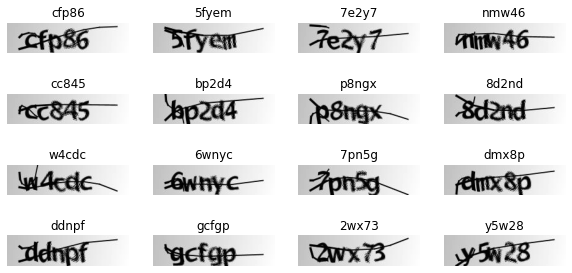

In [6]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# **Crear el Modelo OCR**

In [9]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Calcule el valor de pérdida de tiempo de entrenamiento y agréguelo
        # a la capa usando `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # En el momento de la prueba, devolver las predicciones calculadas
        return y_pred


def build_model():
    # Entradas al modelo
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Primer bloque de conversión
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Segundo bloque de conversión
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Hemos utilizado dos piscinas máximas con tamaño de piscina y zancadas 2.
    # Por lo tanto, los mapas de características submuestreados son 4 veces más pequeños. El número de
    # filtros en la última capa es 64. Reformar en consecuencia antes
    # pasar la salida a la parte RNN del modelo
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Capa de salida
     x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Agregue una capa de CTC para calcular la pérdida de CTC en cada paso
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Defina el modelo
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimice
    opt = keras.optimizers.Adam()
    # Compile el model y regreselo
    model.compile(optimizer=opt)
    return model


# Obtenga el modelo
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

# **Entrenar la red neuronal**

In [10]:
epochs = 100
early_stopping_patience = 10
# Añadir early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 13s 70ms/step - loss: 24.1276 - val_loss: 16.4530
Epoch 2/100
59/59 [==============================] - 2s 42ms/step - loss: 16.3674 - val_loss: 16.3718
Epoch 3/100
59/59 [==============================] - 2s 41ms/step - loss: 16.3513 - val_loss: 16.3775
Epoch 4/100
59/59 [==============================] - 2s 41ms/step - loss: 16.3456 - val_loss: 16.3863
Epoch 5/100
59/59 [==============================] - 2s 41ms/step - loss: 16.3350 - val_loss: 16.3794
Epoch 6/100
59/59 [==============================] - 4s 62ms/step - loss: 16.3319 - val_loss: 16.3907
Epoch 7/100
59/59 [==============================] - 4s 61ms/step - loss: 16.3174 - val_loss: 16.3774
Epoch 8/100
59/59 [==============================] - 4s 60ms/step - loss: 16.3003 - val_loss: 16.3248
Epoch 9/100
59/59 [==============================] - 4s 62ms/step - loss: 16.2817 - val_loss: 16.2564
Epoch 10/100
59/59 [==============================] - 3s 47ms/step - loss: 16.232

# **Predicciones**

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

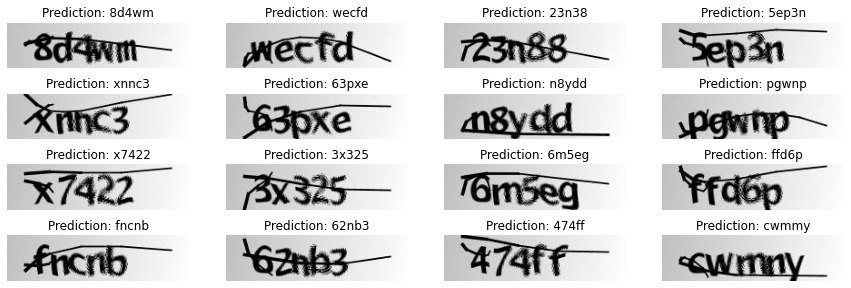

In [11]:
# Obtenga el modelo de predicción extrayendo capas hasta la capa de salida
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# Una función de utilidad para decodificar la salida de la red.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Utilice la búsqueda codiciosa. Para tareas complejas, puede utilizar la búsqueda por haz
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterar sobre los resultados y recuperar el texto.
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Verificar los resultados en algunas muestras de validación.
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

KeyError: ignored

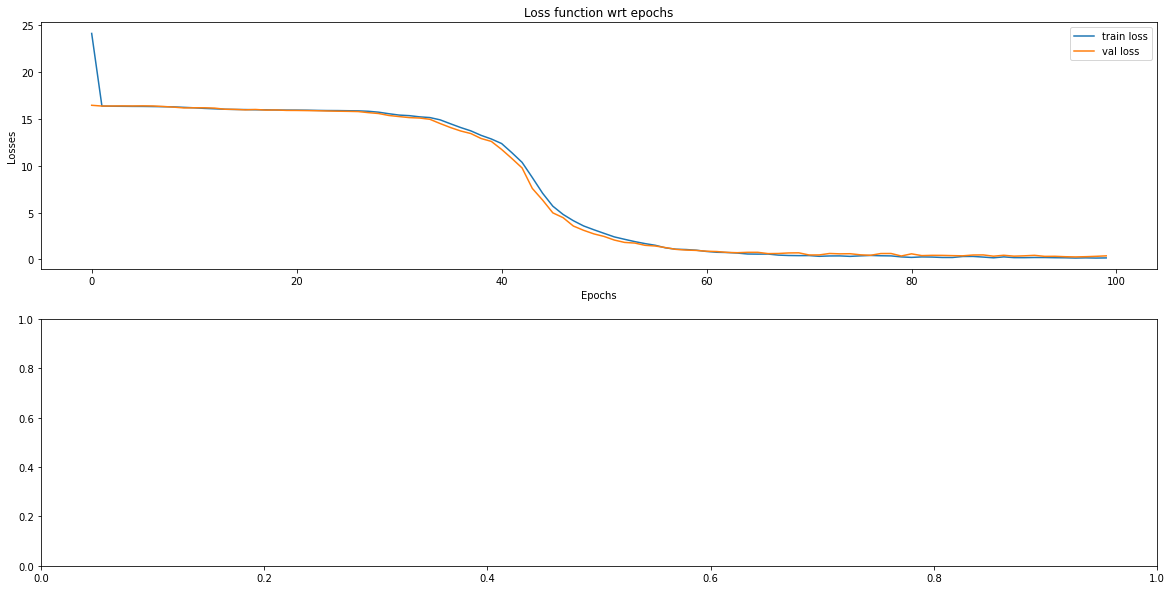

In [14]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss','val loss'])
plt.title('Loss function wrt epochs')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train acc' , 'val acc'])
plt.title('Model accuracy wrt Epoch')